# Testing the two-level asymptotic form of `Whirl2d`

In [487]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a body undergoing a weak oscillatory translation in `x` direction 

In [488]:
Npts = 64
rad = 1.0
xcent = [0.0,0.0]
ang = 0.0
b1 = Bodies.Circle(Npts,rad,xcent,ang)

#xcent = [4.0,0.0]
#b2 = Bodies.Circle(Npts,rad,xcent,ang)

Body: number of points = 64, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]


### Set the streaming motion

In [489]:
nbody = 1
sparams = Array{NavierStokes.StreamingParams}(nbody)

ϵ = 0.1  # A/R

Ω = 1.0
T = 2π/Ω
X₁ = 1.0
X₂ = 0.0
Y₁ = 0.0
Y₂ = 0.0
ϕx₁ = 0.0
ϕy₁ = 0.0
ϕx₂ = 0.0
ϕy₂ = 0.0
sparams[1] = NavierStokes.StreamingParams(Ω,ϵ,X₁,ϕx₁,Y₁,ϕy₁)
NavierStokes.set_oscil_motion!(b1,sparams[1])

#sparams[2] = NavierStokes.StreamingParams(Ω,ϵ,X₂,ϕx₂,Y₂,ϕx₂)
#NavierStokes.set_oscil_motion!(b2,sparams[2])

(::X) (generic function with 1 method)

### Create a domain with this body in it

In [490]:
xmin = [-4.0,-4.0]
xmax = [4.0,4.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b1)
#dom = Systems.add_body(dom,b2)

Domain: xmin = [-4.0, -4.0], xmax = [4.0, 4.0]
number of bodies = 1
Body: number of points = 64, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [491]:
Δx = 0.08
dom = Systems.add_grid(dom,Δx)
x = Grids.xcell(dom.grid);
y = Grids.ycell(dom.grid);

### Set the physical and time parameters

In [492]:
Re = 40
physparams = NavierStokes.set_freestream([0.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α,sparams)
tparams

Time step size 0.04

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [493]:
@time ops = NavierStokes.set_operators_two_level_body!(dom,params);
A⁻¹,L⁻¹,B₁ᵀ,B₂,S⁻¹,S₀⁻¹,r₁,r₂ = ops

  3.893238 seconds (1.92 M allocations: 481.896 MiB, 5.01% gc time)


(Whirl2d.NavierStokes.A⁻¹, Whirl2d.NavierStokes.L⁻¹, Whirl2d.NavierStokes.B₁ᵀ, Whirl2d.NavierStokes.B₂, Whirl2d.NavierStokes.S⁻¹, Whirl2d.NavierStokes.S₀⁻¹, Whirl2d.NavierStokes.r₁, Whirl2d.NavierStokes.r₂)

### Create an initial solution structure

In [494]:
s = NavierStokes.TwoLevelBodySoln(dom)
hist = [s]
TimeMarching.ifherk!(s,tparams,A⁻¹,B₁ᵀ,B₂,S⁻¹,S₀⁻¹,r₁,r₂)

Solution: t = 0.04


### Advance the solution

In [495]:
@time for i = 1:ceil(Int,T/tparams.Δt)
    s = TimeMarching.ifherk!(s,tparams,A⁻¹,B₁ᵀ,B₂,S⁻¹,S₀⁻¹,r₁,r₂)
    push!(hist,s)
end
s

  8.474543 seconds (716.33 k allocations: 2.697 GiB, 9.71% gc time)


Solution: t = 6.320000000000005


#### Average over the last period

In [475]:
savg = NavierStokes.TwoLevelBodySoln(dom)
nper = floor(Int,T/tparams.Δt)
ψ = [zeros(u) for u in savg.u];
for i in length(hist)-nper+1:length(hist)
    savg.u .+= hist[i].u
    ψ .-= L⁻¹(hist[i].u)
end
savg.u ./= nper
ψ ./= nper

2-element Array{Array{Float64,2},1}:
 [0.00894387 0.00894222 … -0.00922195 -0.00922233; 0.0090803 0.00908068 … -0.00935856 -0.00935692; … ; 0.00899608 0.0089952 … -0.00927483 -0.00927445; 0.00886086 0.008858 … -0.00913947 -0.00914106]
 [0.572357 0.580695 … -0.589011 -0.580456; 0.58103 0.589759 … -0.597827 -0.588885; … ; -0.559223 -0.567729 … 0.576006 0.567314; -0.550818 -0.558944 … 0.567429 0.559114]                             

### Plot the solution

#### Level 1 solution

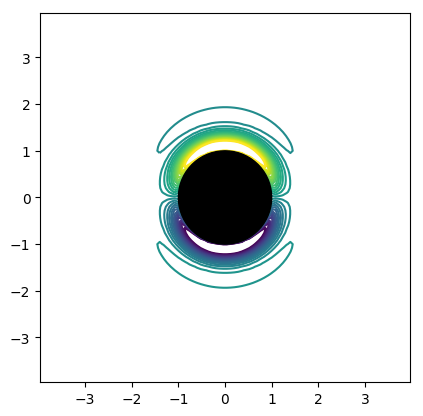

(-3.96, 3.96, -3.96, 3.96)

In [497]:
contour(x,y,transpose(hist[end].u[1][dom.grid.cellint[1],dom.grid.cellint[2]]/Δx),linspace(-5,5,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

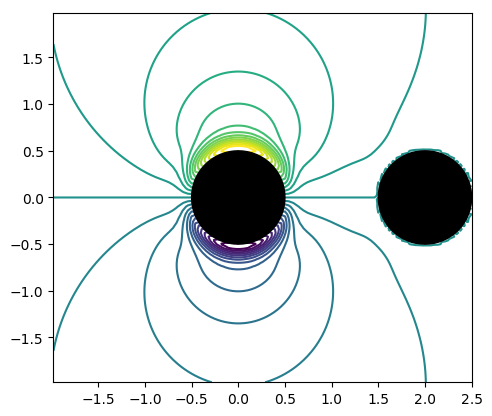

(-1.98, 2.5, -1.98, 1.98)

In [255]:
contour(x,y,tranpose(hist[end].ψ[1][dom.grid.cellint[1],dom.grid.cellint[2]]*Δx),31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

#### Level 2 mean solution

In [379]:
contour(x,y,savg.u[2][dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-20,20,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

LoadError: [91mUndefVarError: savg not defined[39m

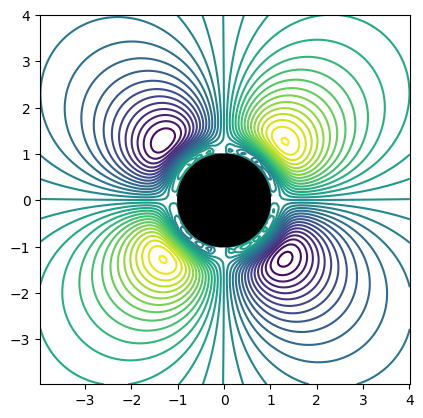

(-3.97, 4.01, -3.97, 4.01)

In [476]:
contour(x,y,ψ[2][dom.grid.cellint[1],dom.grid.cellint[2]]*Δx,31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

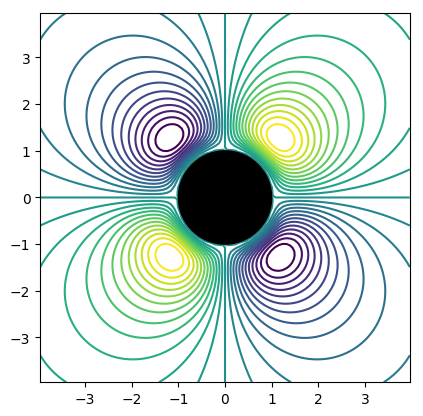

(-3.96, 3.96, -3.96, 3.96)

In [498]:
contour(x,y,transpose(-L⁻¹(hist[end].u)[2][dom.grid.cellint[1],dom.grid.cellint[2]]*Δx),31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

### Sample the computed solution

In [404]:
using Interpolations

In [456]:
typeof(hist)

Array{Whirl2d.ConstrainedSoln{Array{Array{Float64,2},1},Array{Array{Float64,2},1}},1}

In [454]:
xsamp = [2.0,1.5]
ysamp = [0.0,1.5]
ψsamp = [Float64[] for x in xsamp]
uxsamp = [Float64[] for x in xsamp]
uysamp = [Float64[] for x in xsamp]
tsamp = Float64[]
for i = 1:length(hist5)
    push!(tsamp,hist5[i].t)
    ψ = ϵ*hist[i].ψ[1]+ϵ^2*hist[i].ψ[2]
    ux, uy = Grids.curl(dom.grid,ψ)
    ψitp = interpolate((Grids.xcell(dom.grid),Grids.ycell(dom.grid)),ψ[dom.grid.cellint[1],dom.grid.cellint[2]]*Δx,Gridded(Linear()))
    uxitp = interpolate((Grids.xfacex(dom.grid),Grids.yfacex(dom.grid)),ux[dom.grid.facexint[1],dom.grid.facexint[2]],Gridded(Linear()))
    uyitp = interpolate((Grids.xfacey(dom.grid),Grids.yfacey(dom.grid)),uy[dom.grid.faceyint[1],dom.grid.faceyint[2]],Gridded(Linear()))    
    for j = 1:length(xsamp)
        push!(ψsamp[j],ψitp[xsamp[j],ysamp[j]])
        push!(uxsamp[j],uxitp[xsamp[j],ysamp[j]])
        push!(uysamp[j],uyitp[xsamp[j],ysamp[j]])
    end
end

In [277]:
include(joinpath(Pkg.dir("whirl2d"), "src/Streaming.jl"))
import Streaming

In [278]:
Re = 40.0
ϵ = 0.1
p = Streaming.Params(ϵ,Re)
xmin = -6.0
xmax = 6.0
N = 301
x = [xmin + (j-1)*(xmax-xmin)/(N-1) for i=1:N, j=1:N];
y = [xmin + (i-1)*(xmax-xmin)/(N-1) for i=1:N, j=1:N];
Nᵣ = 500
rmax = √2*xmax
r = collect(linspace(1,rmax,Nᵣ))
g = Streaming.Grid(x,y)

2-dimensional evaluation grid


In [279]:
s₁ = Streaming.FirstOrder(p,r)
s̄₂ = Streaming.SecondOrderMean(p,r)
s₂ = Streaming.SecondOrder(p,r)

Amplitude of order 2 streaming exact solution


In [280]:
t = 0.0
s = Streaming.Evaluate(t,p,g,s₁,s̄₂,s₂)

Streaming exact solution at t = 0.0


#### Rescale the solution with given radius and frequency

In [281]:
Rnew = 0.5
Ωnew = 1.0
sr, gr = Streaming.Rescale(s,g,Rnew,Ωnew)

(Streaming exact solution at t = 0.0
, 2-dimensional evaluation grid
)

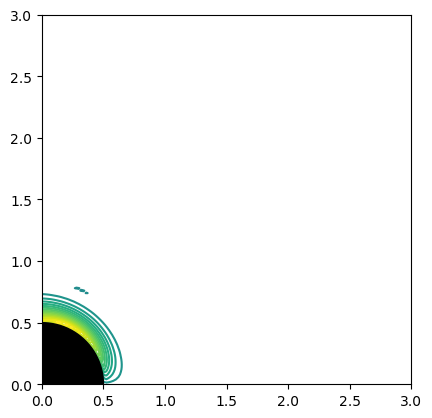

(0, 3.0)

In [285]:
contour(gr.x,gr.y,sr.ω,linspace(-1,1,30))
R = 0.5
zc = R*exp.(im*linspace(0,2π,100))
fill(real(zc),imag(zc),color="k",zorder=2)
axis("scaled")
xlim(0,maximum(gr.x))
ylim(0,maximum(gr.y))

### Sample the history at a few points

In [390]:
x = [2.0,1.5]
y = [0.0,1.5]
gsamp = Streaming.Grid(x,y)

1-dimensional evaluation grid


In [391]:
t₀ = 0.0
t₁ = 10*2π
Δt = 2π/40
tr = t₀:Δt:t₁

0.0:0.15707963267948966:62.83185307179586

In [392]:
h2 = Streaming.Evaluate(tr,p,gsamp,s₁,s̄₂,s₂);

In [ ]:
Rnew = 0.5
Ωnew = 1.0
hr, gr = Streaming.Rescale(h,gsamp,Rnew,Ωnew)

In [393]:
uxex2, uyex2 = Streaming.cartesian(h2,gsamp);

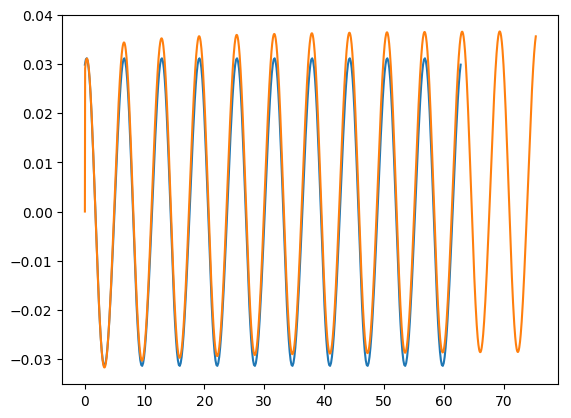

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3741fe3d0>
 PyObject <matplotlib.lines.Line2D object at 0x3759e3c10>

In [455]:
plot(h.t,uxex[1],tsamp,uxsamp[1])

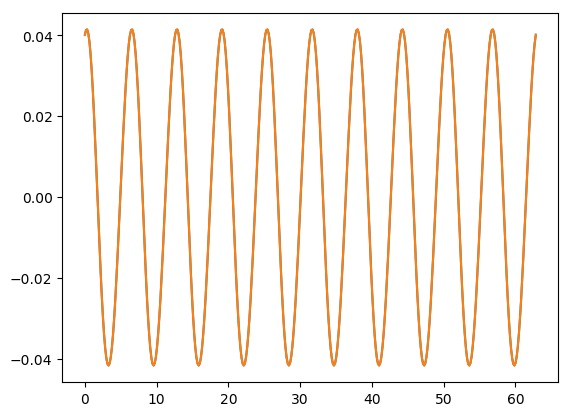

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x340c8d6d0>
 PyObject <matplotlib.lines.Line2D object at 0x340c8d8d0>

In [395]:
plot(tsamp,uxsamp[1])